<a href="https://colab.research.google.com/github/andreoniriccardo/twitter-sentiment-analysis/blob/main/Distance%20Learning%20Twitter%20Sentiment%20Analysis%20w%20snscrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install dependencies
!pip install snscrape
!pip install emoji
!python3 -m nltk.downloader stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=1aca9a9f5c5472786d23b2d2864060023cea46df08537c6a26e75f901cf6e5bc
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# import required libraries
import snscrape.modules.twitter as sntwitter
import pandas as pd
from IPython.display import clear_output
import regex as re
import emoji
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# define function to retrieve tweets for a defined day and topic
def fetch_tweets(query='a', n_of_tweets='100', language='en', from_date='2020-01-01', to_date='2020-12-31'):
  query = str(query)
  # combine the query string
  query_str = query + " lang:" + language + " until:" + to_date + " since:" + from_date
  
  # fetch the tweets
  tweets_list = []
  for tweet in sntwitter.TwitterSearchScraper(query_str).get_items():
    if len(tweets_list) == n_of_tweets:
        break
    else:
        tweets_list.append([tweet.date, tweet.username, tweet.content])
  
  # store the tweets in a df
  columns = ['Time', 'User', 'Tweet']
  df = pd.DataFrame(tweets_list, columns=columns)
  return df

In [ ]:
# create dates array
dates = list(pd.date_range(start='01/01/20', end='12/31/20'))

def toYYYYMMDDmmmm(my_date):
  my_date = my_date.strftime("%Y-%m-%d")
  return my_date

dates_UTC = list(map(toYYYYMMDDmmmm, dates))

In [44]:
# specity query topic and number of tweets per period
query = 'distance learning'
n_of_tweets = 500

**Attention!** Only run the following cell if you don't have a pre-saved dataframe.
If you already have a dataset, skip to the "load pre-saved dataframe" cell.

In [ ]:
# fetch the tweets

# initialize df
columns = ['Time', 'User', 'Tweet']
df = pd.DataFrame(columns=columns)

for i in range(0, len(dates_UTC)-1):
  # specify from and to date
  from_date = dates_UTC[i]
  to_date = dates_UTC[i+1]

  current_df = fetch_tweets(query=query, n_of_tweets=n_of_tweets, language='en', from_date=from_date, to_date=to_date)
  df = pd.concat([df, current_df], ignore_index=True)
  clear_output(wait=True)
  print(i, "/", len(dates_UTC)-1)

364 / 365


In [ ]:
# preview of the dataframe 
df.head()

,Time,User,Tweet
0,2020-01-01 23:49:16+00:00,JJClaptonWrites,2012: the year I finally had to give up any ho...
1,2020-01-01 20:44:20+00:00,ClientSDL,SDL for #EducationandTraining #Teaching #Learn...
2,2020-01-01 19:32:55+00:00,stinkingflower,"@Ali_Davis At 58, I'm going for my 3rd Degree,..."
3,2020-01-01 15:40:08+00:00,ITGovernanceEU,📚 Distance learning offers you a cost effectiv...
4,2020-01-01 14:04:15+00:00,PrepperWebsite,INFOGRAPHIC: #History of Online Learning https...


In [ ]:
# export df as csv file
df.to_csv('distance_learning_df.csv')

In [4]:
# load pre-saved dataframe
df = pd.read_csv("500_per_day.csv", index_col=0)
df.head()

,Time,User,Tweet
0,2020-01-01 23:49:16+00:00,JJClaptonWrites,2012: the year I finally had to give up any ho...
1,2020-01-01 20:44:20+00:00,ClientSDL,SDL for #EducationandTraining #Teaching #Learn...
2,2020-01-01 19:32:55+00:00,stinkingflower,"@Ali_Davis At 58, I'm going for my 3rd Degree,..."
3,2020-01-01 15:40:08+00:00,ITGovernanceEU,📚 Distance learning offers you a cost effectiv...
4,2020-01-01 14:04:15+00:00,PrepperWebsite,INFOGRAPHIC: #History of Online Learning https...


In [5]:
# check column type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153443 entries, 0 to 153442
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Time    153443 non-null  object
 1   User    153443 non-null  object
 2   Tweet   153443 non-null  object
dtypes: object(3)
memory usage: 4.7+ MB


In [6]:
df['Time']= pd.to_datetime(df['Time'])

## CLEAN THE TWEETS
Using [RegEx](https://regexr.com/), and core Python functions:
- remove @usernames
- remove http and https links
- remove emojis 🙂
- remove #hashtag sign but keep the text
- remove duplicates

Second function, using [NLTK](https://www.nltk.org/).
- remove stopwords




Resources:
- https://stackoverflow.com/questions/64719706/cleaning-twitter-data-pandas-python
- https://aronakhmad.medium.com/twitter-data-cleaning-using-python-db1ec2f28f08

In [7]:
# define function for tweet cleaning
def tweet_cleaner(tweet):
  tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove @usernames
  tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links  
  tweet = tweet.replace("#", "").replace("_", " ") # remove hashtag sign but keep the text
  tweet = emoji.replace_emoji(tweet) # remove Emojis
  tweet = " ".join(tweet.split()) # remove unecessary spaces
  return tweet

In [8]:
test = "Hello @username http://www.google.it/ World! #hello_world 🙂"
print(tweet_cleaner(test))

Hello World! hello world


In [9]:
# define function for stopwords removing
stop_words = stopwords.words('english') # load stopwords list for english language
stop_words.remove('not') # remove 'not' from stopwords list
def remove_stopwords(tweet):
  tweet = " ".join([word for word in tweet.split() if word not in stop_words])
  return tweet

In [10]:
# clean the dataframe
df_cleaned = df.copy()
df_cleaned['Tweet'] = df_cleaned['Tweet'].map(lambda x: tweet_cleaner(x))
df_cleaned['Tweet'] = df_cleaned['Tweet'].map(lambda x: remove_stopwords(x))

In [11]:
# remove duplicate tweets
df_cleaned = df_cleaned.drop_duplicates('Tweet', keep='first')

In [12]:
df_cleaned

,Time,User,Tweet
0,2020-01-01 23:49:16+00:00,JJClaptonWrites,2012: year I finally give hope going uni I get...
1,2020-01-01 20:44:20+00:00,ClientSDL,SDL EducationandTraining Teaching LearningandD...
2,2020-01-01 19:32:55+00:00,stinkingflower,"Davis At 58, I'm going 3rd Degree, masters his..."
3,2020-01-01 15:40:08+00:00,ITGovernanceEU,Distance learning offers cost effective altern...
4,2020-01-01 14:04:15+00:00,PrepperWebsite,INFOGRAPHIC: History Online Learning college d...
...,...,...,...
153436,2020-12-30 10:09:21+00:00,KnightbusSci,Abu Dhabi schools - distance learning commence...
153437,2020-12-30 10:04:35+00:00,Stafford_Global,The data industry offers lucrative career oppo...
153439,2020-12-30 10:00:47+00:00,MLUniKent,We hope enjoyed series posts reflecting highli...
153440,2020-12-30 09:58:37+00:00,jurijkovalenok1,Oh Uncle Elon Musk ))) A engineering notes phy...


## Exploratory Data Analysis

Resources:
- https://towardsdatascience.com/8-visualizations-with-python-to-handle-multiple-time-series-data-19b5b2e66dd0
- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots

In [13]:
tweets_per_day = df_cleaned.groupby([df_cleaned['Time'].dt.date]).size()
tweets_per_day = tweets_per_day.reindex(pd.DatetimeIndex(tweets_per_day.index))

In [60]:
weekly_mean = tweets_per_day.resample('W').mean()
rolling_7d_mean = tweets_per_day.rolling(7, center=True).mean()

Text(0.5, 0, 'Date')

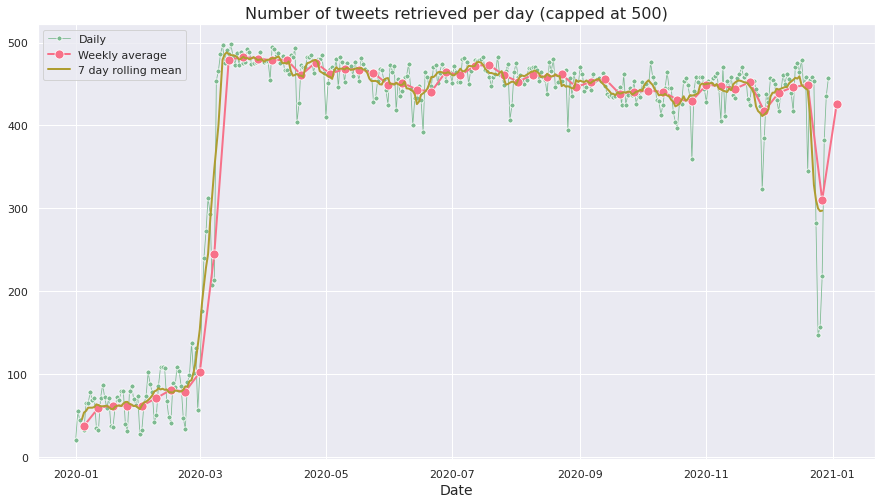

In [68]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style('darkgrid')
palette = iter(sns.husl_palette(5))
sns.set_palette('crest')
g = sns.lineplot(data=tweets_per_day, linewidth=0.8, marker='o', markersize=5, legend='brief', label='Daily')
g = sns.lineplot(data=weekly_mean, color=next(palette), linewidth=2, legend='brief', label='Weekly average', marker='o', markersize=9)
g = sns.lineplot(data=rolling_7d_mean, color=next(palette), linewidth=2, legend='brief', label='7 day rolling mean', markersize=8)
g.axes.set_title(f'Number of tweets retrieved per day (capped at {n_of_tweets})',fontsize=16)
g.set_xlabel("Date",fontsize=14)